In [4]:
# final
from gurobipy import *
from operator import le
from unicodedata import name
from numpy import conjugate
import random
from typing import List
import pandas as pd
from gurobipy import GRB
import numpy as np

In [5]:
def discreteTime(timeWindow, intervalSize):   # O(lenghtOftimeWindow/size)
    tw = []
    currtime = timeWindow[0]
    while (currtime <= timeWindow[1]):
        tw.append(currtime)
        currtime = currtime+intervalSize
    return tw




def distinctCustomer(path,nodeCount):
    customer = 0
    visited = [] # stores index of visited customer
    for i in range(1,len(path)-1):
        node = path[i]
        for j in range(0,len(nodeCount)):
            if(nodeCount[j][0][0] <= node  and node <= nodeCount[j][-1][-1]):
                if(j not in visited):
                    visited.append(j)
                    customer+=1
    return customer,visited


def maxCustomerpath(paths,nodeCount):
    maxPaths = 0
    maxCustomer = 0
    for i in range(0,len(paths)):
        path = paths[i]
        customer,visited = distinctCustomer(path,nodeCount)
        if(maxCustomer < customer):
            maxCustomer = customer
            maxPaths = visited # customers visited
            pathdirection = path
            
    return maxCustomer,maxPaths,pathdirection

def mycallback(model, where):

    if where == GRB.Callback.BARRIER:
        # Barrier callback
        itcnt = model.cbGet(GRB.Callback.BARRIER_ITRCNT)
        primobj = model.cbGet(GRB.Callback.BARRIER_PRIMOBJ)
        dualobj = model.cbGet(GRB.Callback.BARRIER_DUALOBJ)
        priminf = model.cbGet(GRB.Callback.BARRIER_PRIMINF)
        dualinf = model.cbGet(GRB.Callback.BARRIER_DUALINF)
        cmpl = model.cbGet(GRB.Callback.BARRIER_COMPL)
        if abs(primobj - dualobj) <= 5:
            print("Custom gap reached")
            model.terminate()
        print("%d %g %g %g %g %g" % (itcnt, primobj, dualobj, priminf, dualinf, cmpl))
        
def getCustomer(node,nodeCount):
    for i in range(len(nodeCount)):
            smallest_node = nodeCount[i][0][0]
            largest_node = nodeCount[i][-1][-1]
            if(nodeCount[i][0][0] <= node  and node <= nodeCount[i][-1][-1]):
                return i
         
    
def length(u,v,nodeCount,path,idx,ts):
    cust_u = getCustomer(u,nodeCount)
    cust_v = getCustomer(v,nodeCount)
    if(cust_u == cust_v):
        return 0
    # x will start from v and go back to see if cust(x) = cust_u
#     route = []
#     route.append(v)
    curr = idx
    while(True):
        if(curr == 0):
            break
        prev = path[curr]
#         route.append(ts[prev])
        if(getCustomer(ts[prev],nodeCount) == cust_u):
            return 0
        curr = prev
    return 1
        
        
def dfs(v,visited,stack,graph):
        visited[v] = True
        for i in graph[v]:
            if visited[i] == False:
                dfs(i,visited,stack,graph)
        stack.insert(0,v)
def topologicalSort(visited,graph):
        stack =[] 
        dfs(0,visited,stack,graph)
        print ("topologically sorted",stack)
        return stack

def onesPath(graph: List[List[int]],edges1:List[List[int]]) -> List[List[int]]:
    stack = [[0]]
    s=[[]]
    paths = []
    ed=[]
    while stack:
        path = stack.pop()
        e=s.pop()
        node = path[-1]
        if node == len(graph) - 1:
            paths.append(path)
            ed.append(e)
            continue
            
        for i in range(len(graph[node])):
            if(ans[edges1[node][i]]==1):
                stack.append((path + [graph[node][i]]))
                s.append((e+ [edges1[node][i]]))       
            
    return  paths
def searchKey(customer,cust_dict):
    for key in cust_dict.keys():        
        if customer == cust_dict[key]:
            return key

In [6]:
customers = 25
file = "C101.csv"
df = pd.read_csv(file) 
start = 0
speed = 1 # km/min
solomon_capacity = 200


df['XCOORD.'] = df['XCOORD.'] - df['XCOORD.'][0]
df['YCOORD.'] = df['YCOORD.'] - df['YCOORD.'][0]
# df = df[ df['DUE DATE'] >= start + (df['XCOORD.']+df['YCOORD.'])/speed ]
# df.reset_index(inplace = True)

serviceTime = df['SERVICE TIME'][1]
#remove unreachable if(starting time + travelling > end )


print(len(df))
# df = df[ df['DUE DATE'] >= start + (df['XCOORD.']+df['YCOORD.'])/speed ]
timeWindows = [] 
for i in range(0,customers):
    st = df['READY TIME'][i+1]
    if(st%10 != 0):
        st=st - (df['READY TIME'][i+1]%10)
    et = df['DUE DATE'][i+1]
    if(et%10 != 0):
        et = et +(10 - df['DUE DATE'][i+1]%10)
    tw = [st,et]
    timeWindows.append(tw)

discreteTimeWindows = [] # [ [] , [] , [] ]
for i in timeWindows:
    discreteTimeWindows.append(discreteTime(i,10))


def discreteCapacities(C,discrete):
    cap = []
    currC = discrete
    while (currC <= C):
            cap.append(currC)
            currC = currC+discrete
    return cap

capacities = [] #3x3 to store capacities , capacities[i][j][k] -> capacity of ith customer @ discreteTimeWindows[i][j]
for i in range(0,len(discreteTimeWindows)):
    customer_i = []
    dc = discreteCapacities(solomon_capacity,10)
    for j in range(0,len(dc)):
        customer_i.append([dc[j]] * len(discreteTimeWindows[i]))
    capacities.append(customer_i)

time_from_source = []
for i in range(0,customers):
    time_from_source.append(round(math.sqrt((df['XCOORD.'][i+1])**2  + (df['YCOORD.'][i+1])**2 ),2))


demand = []
for i in range(0,customers):
    if(df['DEMAND'][i+1]%10 != 0):# rounding down the demands
        demand.append(df['DEMAND'][i+1] + (10-df['DEMAND'][i+1]))
    else:
        demand.append(df['DEMAND'][i+1])
    

timeMatrix = [] # time from one customer node to another
for i in range(0,customers):
    timeMatrix.append([0]*customers)
for i in range(0,customers):
    for j in range(0,customers):
        if(i==j):
            timeMatrix[i][j] = 0
        elif (i<j):
            euclidean_distance= round( math.sqrt((df['XCOORD.'][i+1]-df['XCOORD.'][j+1])**2  + (df['YCOORD.'][i+1]-df['YCOORD.'][j+1])**2 ),2)
            timeMatrix[i][j] = round(euclidean_distance,2)
            timeMatrix[j][i] = round(euclidean_distance,2)
# print(discreteTimeWindows)
# capacities

101


In [4]:
total_runtime = 0
cust_dict = {}
for i in range(customers):
    cust_dict[i] = i

final_path_list = []
final_path_for_length_calc = []

Iterations = 0
    
VEHICLES = 0
customers_covered = 0

while(len(timeWindows)!=0):
    Iterations+=1
    m1 = Model('VRPTW')
    
    count = 0
    nodeCount = []  # assigns a number to node using count and stores its value

    
    for i in range(0, len(capacities)):
        customer_i = []
        for j in range(0, len(capacities[i])):
            customer_i_j = []
            for k in range(0, len(capacities[i][j])):
                customer_i_j.append(count+1)
                count += 1
            customer_i.append(customer_i_j)
        nodeCount.append(customer_i)

#     print("Number of customers",len(nodeCount))
#     print("Nodes ",nodeCount)
#     print("time from source",time_from_source)

  #  break

    edgeFlows = {} 
    edgeNumber = 0
    x = [] 
    edges = {}  # x[edge #] = (u,v)
    edgesList = []  # stores edge number going out of ith node
    edgesList.append([])  # for s
    
    
    
    # GRAPH CONSTRUCTION
    
    # out of s to starting of each customer
    e = []
    for i in range(0,len(nodeCount)):
        reaching_time = time_from_source[i]
        demand_i = demand[i] 
        for j in range(0, len(discreteTimeWindows[i])):
                        if(reaching_time <= discreteTimeWindows[i][j]):
                            reaching_time_index = j
                            break
        capacity_index = dc.index(0+demand_i)    
    
        x.append(m1.addVar( lb=0, ub=1 , vtype= GRB.CONTINUOUS, name='x[%i]' % edgeNumber ))
        edges['x[%i]' % edgeNumber] = (0,nodeCount[i][capacity_index][reaching_time_index])
        edgeFlows[edgeNumber] = (0,nodeCount[i][capacity_index][reaching_time_index])
        e.append(edgeNumber)
        edgeNumber += 1
                         
    edgesList[0] = e
   

    # edges between consecutive nodes
    for i in range(0, len(nodeCount)):
        for j in range(0, len(nodeCount[i])):
            for k in range(0,len(nodeCount[i][j])-1):
                x.append(m1.addVar( lb=0, ub=1 , vtype= GRB.CONTINUOUS, name='x[%i]' % edgeNumber ))
                edges['x[%i]' % edgeNumber] = (nodeCount[i][j][k], nodeCount[i][j][k+1])
                edgeFlows[edgeNumber] = (nodeCount[i][j][k], nodeCount[i][j][k+1])
                edgesList.append([edgeNumber])
                edgeNumber += 1
            edgesList.append([])


# edge construction (main)
    for i in range(len(nodeCount)):
        for j in range(len(nodeCount[i])):

            tu = nodeCount[i][j][-1]
            start_utime = discreteTimeWindows[i][0]
            end_utime = discreteTimeWindows[i][-1]
            demand_u = demand[i] 
            capacity_u = dc[j] # cap @ node u


            for k in range(len(nodeCount)):
                for l in range(len(nodeCount[k])):

                    sv = nodeCount[k][l][0] # first node of each capacity
                    start_vtime = discreteTimeWindows[k][0]
                    end_vtime = discreteTimeWindows[k][-1]
                    demand_v = demand[k] 
                    capacity_v = dc[l] # cap @ node l


                    if(i != k and start_utime + timeMatrix[i][k] + serviceTime > end_vtime):
                        print("",end='')
                      # not reachable

                    # reaches before sv starting from the last node of u
                    elif(i != k and start_vtime >= end_utime + timeMatrix[i][k]+ serviceTime and capacity_u+demand_v==capacity_v):
                        e = []
                        x.append(m1.addVar( lb=0, ub=1 , vtype= GRB.CONTINUOUS, name='x[%i]' % edgeNumber ))
                        edges['x[%i]' % edgeNumber] = (tu, sv)  # u -> v reachable
                        edgeFlows[edgeNumber] = (tu, sv)
                        e.append(edgeNumber)
                        edgesList[tu].extend(e)
                        edgeNumber += 1


                    elif (i != k and start_vtime < end_utime + timeMatrix[i][k]+serviceTime and capacity_u+demand_v == capacity_v):

                        firstReachableNode_index = 0  # first such that node >= sv
                        for m in range(0, len(discreteTimeWindows[i])):
                            if(timeMatrix[i][k] + discreteTimeWindows[i][m]+serviceTime >= start_vtime):
                                firstReachableNode_index = m
                                break
                        if(firstReachableNode_index > 0):
                                firstReachableNode_index=firstReachableNode_index-1
                        # now starting from firstReachableNode make edges until feasible
                        for n in range(firstReachableNode_index, len(discreteTimeWindows[i])):
                            e = []
                            reachingTime = discreteTimeWindows[i][n]+timeMatrix[i][k]+serviceTime
                            for r in range(0, len(discreteTimeWindows[k])):
                                if(discreteTimeWindows[k][r] >= reachingTime):
                                    x.append(m1.addVar( lb=0, ub=1 , vtype= GRB.CONTINUOUS, name='x[%i]' % edgeNumber ))
                                    edges['x[%i]' % edgeNumber] =(nodeCount[i][j][n], nodeCount[k][l][r])  # u -> v reachable
                                    edgeFlows[edgeNumber] = (nodeCount[i][j][n], nodeCount[k][l][r])
                                    e.append(edgeNumber)
                                    edgesList[nodeCount[i][j][n]].extend(e)
                                    edgeNumber += 1
                                    break



#     print('edge list b4 s t', edgesList)
#     print()

    # all ti to t
    e = []
    for i in range(0, len(nodeCount)):
        for j in range(0,len(nodeCount[i])):
            ti = nodeCount[i][j][-1]
            x.append(m1.addVar( lb=0, ub=1 , vtype= GRB.CONTINUOUS, name='x[%i]' % edgeNumber ))
            edges['x[%i]' % edgeNumber] = (ti , -1)
            edgeFlows[edgeNumber] = (ti , -1)
            # add edge number in edge list
            edgesList[ti].append(edgeNumber)
            edgeNumber += 1
    edgesList.append([])


#     print(edgesList)
    # GRAPH Construction OVER
    # if I add it to  0 edge i'll get flow for 1 at the same edge  , add to 1 customer 2 customer


    offset = edgeNumber


#     flows = [0]*customers
#     for i in range(customers):
#         flows[i] = edgeFlows.copy()
#         keys = edgeFlows.keys()
#         for j in keys:  # stores key values of edgeflows i.e = 0,1,2....
#             x.append(m1.addVar( lb=0, ub=1 , vtype= GRB.CONTINUOUS, name='x[%i]' % edgeNumber ))
#             # remove key and replace it by edge
#             t = flows[i].pop(j)
#             flows[i][edgeNumber] = t
#             edgeNumber += 1

    noc = 0
    # contraint for outgoing flow for a customer
    for i in range(0, len(nodeCount)):  # choose one list from nodeCount
        smallest_node = nodeCount[i][0][0]
        largest_node = nodeCount[i][-1][-1]
        coeff = []
        for j in range(0, len(nodeCount[i])):
            for k in range(0,len(nodeCount[i][j])):
                node = nodeCount[i][j][k]
                for l in range(0,len(edgesList[node])):
                    e = edgesList[node][l]
                    u = edges['x[%i]' % e][0]
                    v = edges['x[%i]' % e][1]
                    if(v<smallest_node or v>largest_node):
                            coeff.append(x[e])
        m1.addConstr(( sum(coeff) == 1  ))
        noc+=1
#     print("outgoing edge lisst :")

    incomingEdgeList = []
    for i in range(0, len(edgesList)):
        incomingEdgeList.append([])  # adding lists in a list
    for i in edges:
        v = edges[i][1]  # u -> v
        edge_no = int(i[2:-1])
        incomingEdgeList[v].append(edge_no)

#     print("incoming edge list: ", incomingEdgeList)
#     print()

    #  constraint : incoming for a customer
    for i in range(0, len(nodeCount)):  # choose one list from nodeCount
        smallest_node = nodeCount[i][0][0]
        largest_node = nodeCount[i][-1][-1]
        coeff = []
        for j in range(0, len(nodeCount[i])):
            for k in range(0,len(nodeCount[i][j])):
                node = nodeCount[i][j][k]
                for l in range(0,len(incomingEdgeList[node])):
                    e = incomingEdgeList[node][l] # edge number of incoming edge
                    
                    u = edges['x[%i]' % e][0]
                    v = edges['x[%i]' % e][1]
            
#                     print(node == v)
                    if(u<smallest_node or u>largest_node):
                        coeff.append(x[e])
        m1.addConstr(( sum(coeff) == 1  ))
        noc+=1

    # constraint for a node incoming = outgoing
    for i in range(0, len(nodeCount)):
        for j in range(0, len(nodeCount[i])):
            for k in range(0,len(nodeCount[i][j])):
                coeff = []
                node = nodeCount[i][j][k]
                for l in range(0, len(incomingEdgeList[node])):
                    e = incomingEdgeList[node][l]
                    coeff.append(x[e])
                for l in range(0, len(edgesList[node])):
                    e = edgesList[node][l]
                    coeff.append(-x[e])
                m1.addConstr(( sum(coeff) == 0 ))
                noc+=1  
            

                                                        
    
                                 
                                 
#     m1.params.Method = 1
#     m1.params.Crossover = 0     

    #minimizing the number of truck leaving S
    objectivefun = []  
    for i in range(0, len(edgesList[0])):
        objectivefun.append(x[edgesList[0][i]])
    obj = sum(objectivefun)
    m1.setObjective(obj,GRB.MINIMIZE)
 

    m1.optimize()
    total_runtime += m1.Runtime
    print("Runtime is :",m1.Runtime)
    print("Objective value : ",m1.objVal)
     
    # ans stores {1:0.5,4:0.9,...}   
    ans = {}
    for v in m1.getVars()[:offset]:
        if (v.x > 0):
            ans[(v.varName[2:-1])]=v.x

                                 
    new_edges = {}   # stores only those edges which are required   {e:(u,v)}
    for key in edges:
        if((key[2:-1]) in ans):
            new_edges[(key[2:-1])] = edges[key]
    
#     print(ans)
                                 
                                 
    graphForpaths = [] # will store outgoing edges
    for i in range(len(edgesList)): # edgesList contains outgoing from each node
        l = []
        for key in new_edges:
            if(new_edges[key][0] == i):  # u = i
                if(new_edges[key][1] == -1):
                    l.append(len(edgesList)-1)
                else:
                    l.append(new_edges[key][1])
        graphForpaths.append(l)
        
    allcustomer = [] # will store customers from longest path + ones path for del 
    # --------------------------------------------------- 
    # ONES PATH
    edges1=[] # stores outgoing edges wtih val > 0
    for i in range(nodeCount[-1][-1][-1]+1):
        edges1.append([])
    for key in new_edges.keys():
        edges1[new_edges[key][0]].append(key)
        
    paths = onesPath(graphForpaths,edges1)  # paths contains all ones path
    for i in range(len(paths)):
        paths[i][-1] = -1
#     print("Ones paths",paths)
   
    for route in paths:
        distict_customers,customer_nodes = distinctCustomer(route,nodeCount)
        customer_occurence = customer_nodes.copy()
        allcustomer+=customer_nodes
        customers_covered += distict_customers
        #----------------------------
        final_str = str()
        final_str = final_str + 'Ones path : Source -> '
    
       
        
        for i in customer_occurence:
            customer_number = searchKey(i,cust_dict)  # search key with value = i (i represents customer)
            final_str = final_str + ''.join(str(customer_number)+ ' -> ')


        final_str = final_str+' Sink '

        final_path_list.append(final_str)

        customer_nodes.sort()  # will store customers in ascending order
        for i in customer_nodes:
            for key, value in cust_dict.items():
                if i == value:
                    cust_dict[key]= -(VEHICLES+1)
        
        VEHICLES+=1
        #---------------------------------------------------------    
    #----------------------------------------------------
    
    
#     print("Edges",new_edges)
#     print("ANS",ans)
    visited = [False]*len(graphForpaths)
    ts = topologicalSort(visited,graphForpaths)
    
    while(True):
        # dp[i] stores maximum length from s to i
        path = [0]*len(ts)                     # stores index of path for which max occurs at i
        dp = [0]*len(ts)
        dp[0] = 1
        for i in range(1,len(ts)):
            u = ts[i]
            for j in range(0,i):
                v = ts[j]
                if(u in graphForpaths[v]): # egde to a prev node always exists
                    # v -> u and if path from s to v contains a node x st cust(x) = cust(u) then also add 0
                    val = length(u,v,nodeCount,path,j,ts)
                    if(val + dp[j] > dp[i]):
                        dp[i] = val + dp[j]
                        path[i] = j
    #             dp[i] = max(dp[i],length(u,v,nodeCount) + dp[j])
    #     print("max length :",dp[-1]-2)
    #     print(path)
    
#         print("index path:",path)
        route = []
        route.append(-1)
        curr = -1
        while(True):
            if(curr == 0):
                break
            prev = path[curr]
            route.append(ts[prev])
            curr = prev

        for l in range(1,len(route)-1):
            del ts[ts.index(route[l])]
            
            
        route.reverse()
        print("other routes :",route)
        if route not in paths:
            print("longest route (repeat):",route)
            break

    
    # now i need longest 
    distict_customers,customer_nodes = distinctCustomer(route,nodeCount)
    customer_occurence = customer_nodes.copy() # customer node stores index of visited customer in order of their occ in routes
    customers_covered+=distict_customers 
#     print("customer_occurence  -->",customer_occurence)
    
#     if(len(customer_nodes) == 0 and customers_covered == customers): # i.e no path other than one exist
#         print("breaking.......")
#         break
    if(len(customer_nodes) == 0): # i.e no path other than one exist
        print("Total customers covered",customers_covered)
        break
    
    
    
    # new addition-----------------
    final_str = str()
    final_str = final_str + 'Source -> '
    
    
#     print("customer dixt->",cust_dict)
    for i in customer_occurence:
        customer_number = searchKey(i,cust_dict)     # search key with value = i (i represents customer)
        final_str = final_str + ''.join(str(customer_number)+ ' -> ')
        
        
    final_str = final_str+' Sink '

    final_path_list.append(final_str)
    
    customer_nodes.sort()  # will store customers in ascending order
    for i in customer_nodes:
        for key, value in cust_dict.items():
            if i == value:
                cust_dict[key]= -(VEHICLES+1)
                
    a = 0
    for i in range(len(cust_dict)):
        if cust_dict[i]>= 0 :
            cust_dict[i] = a
            a+=1
    #----------------------------
    
    
    allcustomer += customer_nodes
    allcustomer = np.unique(allcustomer)
    allcustomer = allcustomer[::-1]

    #-------------------------
    #modify time-windows
    for i in range(0,len(allcustomer)):
        del timeWindows[allcustomer[i]]
        
    for i in range(0,len(allcustomer)):
        del time_from_source[allcustomer[i]]
        
    for i in range(0,len(allcustomer)):
        del demand[allcustomer[i]]
    #----------------------------------
    
                                 
    discreteTimeWindows = []
    for i in timeWindows:
        discreteTimeWindows.append(discreteTime(i, 10))
        
    capacities = [] #3x3 to store capacities , capacities[i][j][k] -> capacity of ith customer @ discreteTimeWindows[i][j]
    for i in range(0,len(discreteTimeWindows)):
        customer_i = []
        dc = discreteCapacities(solomon_capacity,10)
        for j in range(0,len(dc)):
            customer_i.append([dc[j]] * len(discreteTimeWindows[i]))
        capacities.append(customer_i)                        

    # removing visited customer from time matrix
    for row in allcustomer:
        del timeMatrix[row]

    for row in range(0,len(timeMatrix)):                         
        for col in allcustomer:
            del timeMatrix[row][col]
    
    print("                                                                                      ")
    print("Removing ",distict_customers," distinct customer",customer_nodes,"and path is ",route)
    print("----------------------------------------------------------------------------------------------------")
    print("                                                                                      ")
    
#     if(distict_customers != 0):
#         VEHICLES+=1 
    VEHICLES+=1 

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-11
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 1530 rows, 7243 columns and 25962 nonzeros
Model fingerprint: 0x4ae0cdca
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1427 rows and 6567 columns
Presolve time: 0.15s
Presolved: 103 rows, 676 columns, 1672 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+01   5.900000e+01   0.000000e+00      0s
     171    7.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 171 iterations and 0.20 seconds (0.01 work units)
Optimal objective  7.000000000e+00
Runtime is : 0.20600509643554688
Objective value :  7.0
topologically sorted [0, 1301, 286, 1369, 1302, 105, 106, 1181, 5

In [33]:
def getdist(x_0,y_0,x_1,y_1):
    d = math.sqrt((x_1-x_0)**2  + (y_1-y_0)**2 )
    return d
 
final_str = []
for i in final_path_list:
  i = i.split(" ")
  lis = list(i)
  print(lis)
  new_path = []
  for j in range(len(lis)):
    if(lis[j].isdigit()):
        new_path.append(int(lis[j]))
  final_str.append(new_path)

print(final_str)    
total_distance = 0

for i in final_str:
  for j in range(len(i)):
    if j == 0:
      total_distance+=getdist(0,0,df.iloc[i[j]+1]['XCOORD.'],df.iloc[i[j]+1]['YCOORD.'])

    else:
      total_distance+=getdist(df.iloc[i[j-1]+1]['XCOORD.'],df.iloc[i[j-1]+1]['YCOORD.'],df.iloc[i[j]+1]['XCOORD.'], df.iloc[i[j]+1]['YCOORD.'])
  
  total_distance+=getdist(df.iloc[i[-1]+1]['XCOORD.'],df.iloc[i[-1]+1]['YCOORD.'],0,0)
    
print(round(total_distance,2))    

['Source', '->', '13', '->', '14', '->', '21', '->', '3', '->', '23', '->', '', 'Sink', '']
['Source', '->', '11', '->', '8', '->', '19', '->', '0', '->', '', 'Sink', '']
['Ones', 'path', ':', 'Source', '->', '10', '->', '18', '->', '7', '->', '', 'Sink', '']
['Source', '->', '4', '->', '15', '->', '5', '->', '12', '->', '', 'Sink', '']
['Ones', 'path', ':', 'Source', '->', '22', '->', '9', '->', '', 'Sink', '']
['Ones', 'path', ':', 'Source', '->', '6', '->', '17', '->', '16', '->', '', 'Sink', '']
['Ones', 'path', ':', 'Source', '->', '1', '->', '20', '->', '2', '->', '24', '->', '', 'Sink', '']
[[13, 14, 21, 3, 23], [11, 8, 19, 0], [10, 18, 7], [4, 15, 5, 12], [22, 9], [6, 17, 16], [1, 20, 2, 24]]
679.3399999999998


In [5]:
print("Vehicles required : ",VEHICLES)
print("Total Runtime",total_runtime)
print("Number of Iterations",Iterations)
print("Total distance :",total_distance)

Vehicles required :  7
Total Runtime 0.3147163391113281
Number of Iterations 4


In [6]:
print(file)
final_path_list

R101.csv


['Source -> 13 -> 14 -> 21 -> 3 -> 23 ->  Sink ',
 'Source -> 11 -> 8 -> 19 -> 0 ->  Sink ',
 'Ones path : Source -> 10 -> 18 -> 7 ->  Sink ',
 'Source -> 4 -> 15 -> 5 -> 12 ->  Sink ',
 'Ones path : Source -> 22 -> 9 ->  Sink ',
 'Ones path : Source -> 6 -> 17 -> 16 ->  Sink ',
 'Ones path : Source -> 1 -> 20 -> 2 -> 24 ->  Sink ']

In [13]:
file = "C101.csv"
df = pd.read_csv(file) 
df['XCOORD.'] = df['XCOORD.'] - df['XCOORD.'][0]
df['YCOORD.'] = df['YCOORD.'] - df['YCOORD.'][0]

def getdist(x_0,y_0,x_1,y_1):
    d = math.sqrt((x_1-x_0)**2  + (y_1-y_0)**2 )
    return d
 
final_str = [
     [81, 78 ,76, 71, 70, 73, 77, 79, 80],
     [57 ,55 ,54 ,53, 56 ,58, 60, 59],
     [98, 96 ,95 ,94, 92 ,93 ,97 ,100, 99],
     [32, 33 ,31 ,35, 37, 38, 39, 36, 34],
     [13, 17 ,18, 19, 15, 16, 14, 12],
     [90, 87 ,86, 83, 82, 84, 85, 88, 89, 91],
     [43, 42 ,41 ,40, 44, 46, 45, 48, 51, 50, 52 ,49, 47],
     [67, 65 ,63, 62 ,74, 72, 61, 64, 68 ,66, 69],
     [5, 3, 7 ,8, 10 ,11, 9, 6, 4, 2, 1, 75],
     [20, 24, 25 ,27, 29, 30, 28, 26, 23, 22, 21]
    
]
for i in range(len(final_str)):
    for j in range(len(final_str[i])):
        final_str[i][j]-=1
 
total_distance = 0

for i in final_str:
  for j in range(len(i)):
    if j == 0:
#       print(df.iloc[i[j]+1]['XCOORD.'],df.iloc[i[j]+1]['YCOORD.'])
      total_distance+=getdist(0,0,df.iloc[i[j]+1]['XCOORD.'],df.iloc[i[j]+1]['YCOORD.'])
#       print(total_distance)

    else:
      total_distance+=getdist(df.iloc[i[j-1]+1]['XCOORD.'],df.iloc[i[j-1]+1]['YCOORD.'],df.iloc[i[j]+1]['XCOORD.'], df.iloc[i[j]+1]['YCOORD.'])
  
  total_distance+=getdist(df.iloc[i[-1]+1]['XCOORD.'],df.iloc[i[-1]+1]['YCOORD.'],0,0)
    
print(round(total_distance,2))    


828.94


Text(0, 0.5, 'Frequency')

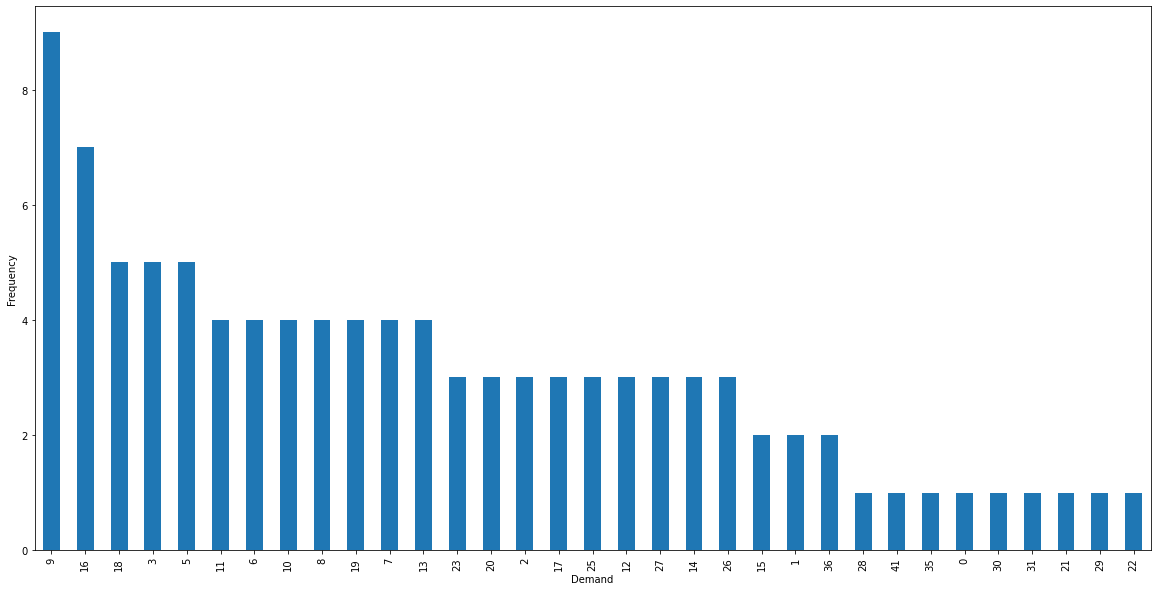

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
df['DEMAND'].value_counts().sort_values(ascending = False).plot(kind='bar')
plt.xlabel("Demand")
plt.ylabel("Frequency")

##### 

In [29]:
df.head()

,CUST NO.,XCOORD.,YCOORD.,DEMAND,READY TIME,DUE DATE,SERVICE TIME
0,1,0,0,0,0,230,0
1,2,6,14,10,161,171,10
2,3,0,-18,7,50,60,10
3,4,20,10,13,116,126,10
4,5,20,-15,19,149,159,10
